<a href="https://colab.research.google.com/gist/Rihankim18/ac3440c297d5092ed3cef7d62a4c4e21/btc_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyupbit

In [8]:
!pip install prophet

In [9]:
import pyupbit
import numpy as np

In [10]:
# 300시간 동안의 3분봉 데이터를 가져옵니다.
# 3분봉 개수 = 300시간 * (60분 / 3분) = 300 * 20 = 6000개
df = pyupbit.get_ohlcv("KRW-BTC", interval="minute3", count=6000)
df

,open,high,low,close,volume,value
2025-07-25 03:30:00,161742000.0,161742000.0,161610000.0,161644000.0,1.253899,2.027812e+08
2025-07-25 03:33:00,161690000.0,161742000.0,161463000.0,161468000.0,1.413263,2.284050e+08
2025-07-25 03:36:00,161468000.0,161655000.0,161439000.0,161449000.0,1.807757,2.918873e+08
2025-07-25 03:39:00,161449000.0,161627000.0,161440000.0,161509000.0,0.972853,1.570925e+08
2025-07-25 03:42:00,161509000.0,161509000.0,161407000.0,161434000.0,0.538535,8.694205e+07
...,...,...,...,...,...,...
2025-08-06 15:30:00,159621000.0,159621000.0,159503000.0,159603000.0,0.338758,5.406047e+07
2025-08-06 15:33:00,159603000.0,159622000.0,159556000.0,159619000.0,1.797350,2.868649e+08
2025-08-06 15:36:00,159619000.0,159620000.0,159566000.0,159618000.0,0.759192,1.211697e+08
2025-08-06 15:39:00,159618000.0,159700000.0,159580000.0,159700000.0,1.958428,3.126187e+08


In [11]:
#시간(ds)와 종가(y)값만 남김
df = df.reset_index()
df['ds'] = df['index']
df['y'] = df['close']
data = df[['ds','y']]
data

,ds,y
0,2025-07-25 03:30:00,161644000.0
1,2025-07-25 03:33:00,161468000.0
2,2025-07-25 03:36:00,161449000.0
3,2025-07-25 03:39:00,161509000.0
4,2025-07-25 03:42:00,161434000.0
...,...,...
5995,2025-08-06 15:30:00,159603000.0
5996,2025-08-06 15:33:00,159619000.0
5997,2025-08-06 15:36:00,159618000.0
5998,2025-08-06 15:39:00,159700000.0


In [14]:
#prophet 불러옴
from prophet import Prophet

In [15]:
#학습
model = Prophet()
model.fit(data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpslmctkzn/s6_3_9af.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpslmctkzn/ltav70a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33860', 'data', 'file=/tmp/tmpslmctkzn/s6_3_9af.json', 'init=/tmp/tmpslmctkzn/ltav70a5.json', 'output', 'file=/tmp/tmpslmctkzn/prophet_model7er883so/prophet_model-20250806064933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:49:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
# 24시간 미래 예측을 3분 단위로 변경
# 24시간은 3분봉이 총 480개입니다 (24시간 * 60분 / 3분)
future = model.make_future_dataframe(periods=480, freq='3min')
forecast = model.predict(future)

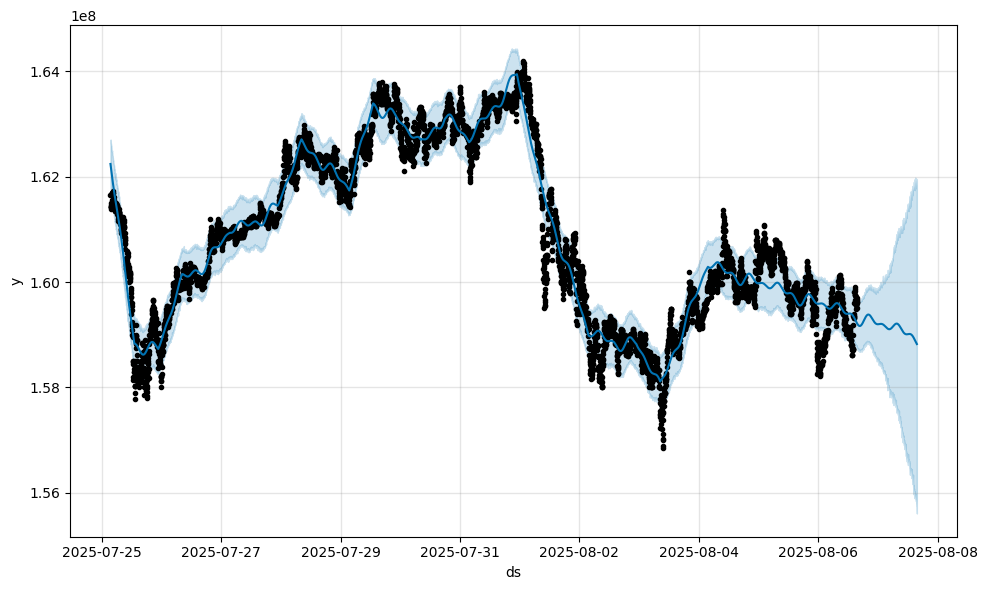

In [17]:
#그래프1
fig1 = model.plot(forecast)

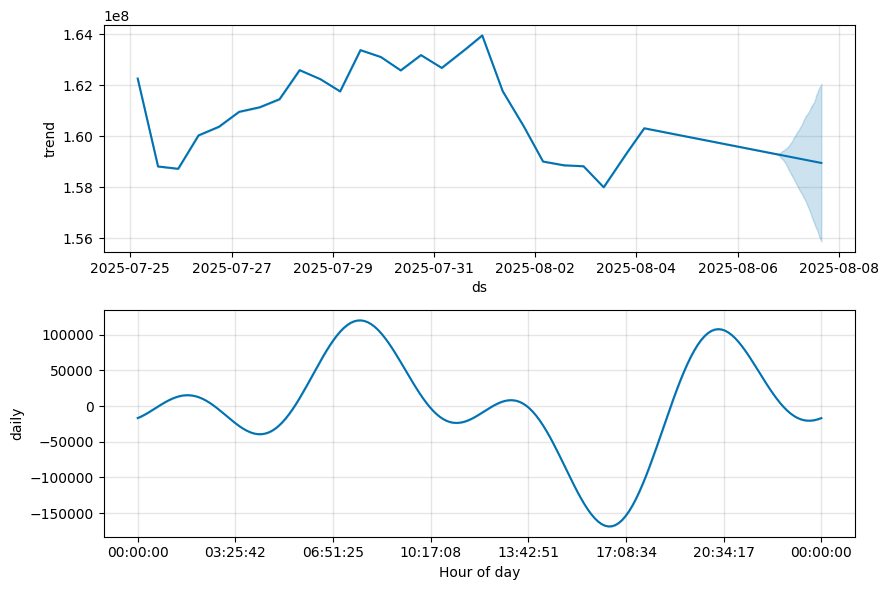

In [18]:
#그래프2
fig2 = model.plot_components(forecast)

In [19]:
#매수 시점의 가격
nowValue = pyupbit.get_current_price("KRW-BTC")
nowValue

159715000.0

In [23]:
#종가의 가격을 구함

#현재 시간이 자정 이전
closeDf = forecast[forecast['ds'] == forecast.iloc[-1]['ds'].replace(hour=9)]

#현재 시간이 자정 이후
if len(closeDf) == 0:
  closeDf = forecast[forecast['ds'] == data.iloc[-1]['ds'].replace(hour=9)]

# 가장 마지막으로 예측된 시점의 종가를 구함
closeValue = forecast.iloc[-1]['yhat']
closeValue

np.float64(158822051.42939597)

In [24]:
#구체적인 가격
print("현재 시점 가격: ", nowValue)
print("종가의 가격: ", closeValue)

현재 시점 가격:  159715000.0
종가의 가격:  158822051.42939597


In [25]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-07-25 03:30:00,1.622690e+08,1.617911e+08,1.626952e+08,1.622690e+08,1.622690e+08,-26034.898843,-26034.898843,-26034.898843,-26034.898843,-26034.898843,-26034.898843,0.0,0.0,0.0,1.622430e+08
1,2025-07-25 03:33:00,1.622511e+08,1.617644e+08,1.627066e+08,1.622511e+08,1.622511e+08,-27488.683898,-27488.683898,-27488.683898,-27488.683898,-27488.683898,-27488.683898,0.0,0.0,0.0,1.622236e+08
2,2025-07-25 03:36:00,1.622331e+08,1.617306e+08,1.626728e+08,1.622331e+08,1.622331e+08,-28885.559506,-28885.559506,-28885.559506,-28885.559506,-28885.559506,-28885.559506,0.0,0.0,0.0,1.622042e+08
3,2025-07-25 03:39:00,1.622152e+08,1.617303e+08,1.626469e+08,1.622152e+08,1.622152e+08,-30219.429955,-30219.429955,-30219.429955,-30219.429955,-30219.429955,-30219.429955,0.0,0.0,0.0,1.621849e+08
4,2025-07-25 03:42:00,1.621972e+08,1.616672e+08,1.626315e+08,1.621972e+08,1.621972e+08,-31484.319198,-31484.319198,-31484.319198,-31484.319198,-31484.319198,-31484.319198,0.0,0.0,0.0,1.621657e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,2025-08-07 15:30:00,1.589638e+08,1.557979e+08,1.618901e+08,1.559292e+08,1.620072e+08,-124708.033690,-124708.033690,-124708.033690,-124708.033690,-124708.033690,-124708.033690,0.0,0.0,0.0,1.588391e+08
6476,2025-08-07 15:33:00,1.589630e+08,1.557660e+08,1.618389e+08,1.559120e+08,1.620197e+08,-128319.538515,-128319.538515,-128319.538515,-128319.538515,-128319.538515,-128319.538515,0.0,0.0,0.0,1.588347e+08
6477,2025-08-07 15:36:00,1.589622e+08,1.558590e+08,1.618593e+08,1.558959e+08,1.620322e+08,-131828.962725,-131828.962725,-131828.962725,-131828.962725,-131828.962725,-131828.962725,0.0,0.0,0.0,1.588303e+08
6478,2025-08-07 15:39:00,1.589614e+08,1.556726e+08,1.619446e+08,1.558885e+08,1.620447e+08,-135227.348248,-135227.348248,-135227.348248,-135227.348248,-135227.348248,-135227.348248,0.0,0.0,0.0,1.588261e+08
